# Sandbox 

Sandbox for main python scripts

# Generate tests

In [18]:
import sys
sys.path.append("..")
from pathlib import Path
import geopandas as gpd
import osmnx as ox

import networkx as nx
from morpho.layers import clean_gdf, get_graph, get_polygons

In [19]:
city = "Raleigh"

In [20]:
data_folder = Path("../../data")

In [21]:
def get_polygons(city):
    input_file = data_folder / "0_boundaries" / city / (city + ".gpkg")

    gdf = gpd.read_file(input_file, driver="GPKG")
    if len(gdf) > 200:
        raise ValueError(f"File too large: {len(gdf)} polygons.")

    # Force gdf projection
    gdf = ox.project_gdf(gdf, to_crs="epsg:4326", to_latlong=False)

    # Create unique ID
    gdf = gdf.reset_index(drop=True)
    gdf["UID"] = gdf.index

    gdf["collapse"] = 0
    gdf_collapsed = gdf.dissolve(by="collapse")

    return gdf, gdf_collapsed

In [22]:
city = "Raleigh"
gdf, gdf_collapsed = get_polygons(city)
gdf = gdf.head()
gdf = clean_gdf(gdf)
print(gdf)

  STATEFP COUNTYFP TRACTCE        GEOID    NAME             NAMELSAD  MTFCC   
0      37      183  052704  37183052704  527.04  Census Tract 527.04  G5020  \
1      37      183  053724  37183053724  537.24  Census Tract 537.24  G5020   
2      37      183  051502  37183051502  515.02  Census Tract 515.02  G5020   
3      37      183  051102  37183051102  511.02  Census Tract 511.02  G5020   
4      37      183  052407  37183052407  524.07  Census Tract 524.07  G5020   

  FUNCSTAT    ALAND  AWATER     INTPTLAT      INTPTLON   
0        S  2922352   30951  +35.8408976  -078.5922622  \
1        S  5862051   77679  +35.8979250  -078.7499213   
2        S  2675640       0  +35.8087069  -078.6831384   
3        S  1738787       0  +35.7819418  -078.6658270   
4        S  3592937   24403  +35.7846005  -078.7100677   

                                            geometry  UID  collapse   
0  MULTIPOLYGON (((-78.60592 35.83491, -78.60589 ...    0         0  \
1  MULTIPOLYGON (((-78.76784 35.89

In [23]:
def test_missing_lat():
    """Test that missing latitude is below 10%"""
    missing_lon = gdf["lat"].isna().sum()
    assert missing_lon / len(gdf) < 0.1


def test_missing_lon():
    """Test that missing longitude is below 10%"""
    missing_lon = gdf["lon"].isna().sum()
    assert missing_lon / len(gdf) < 0.1

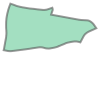

In [30]:
gdf['geometry'][0]

In [32]:
# def test_get_graph():
polygon = gdf["geometry"][0]
G = get_graph(polygon)

In [25]:
polygon

NameError: name 'polygon' is not defined

### get_bearings

In [28]:
import osmnx as ox
import geopandas as gpd
from pathlib import Path

import sys
sys.path.append("..")
from morpho.helpers import get_bearings
from morpho.layers import clean_gdf, get_graph, get_entropy

In [31]:
data_folder = Path("../../data")

def get_polygons(city):
    input_file = data_folder / "0_boundaries" / city / (city + ".gpkg")

    gdf = gpd.read_file(input_file, driver="GPKG")
    if len(gdf) > 200:
        raise ValueError(f"File too large: {len(gdf)} polygons.")

    # Force gdf projection
    gdf = ox.project_gdf(gdf, to_crs="epsg:4326", to_latlong=False)

    # Create unique ID
    gdf = gdf.reset_index(drop=True)
    gdf["UID"] = gdf.index

    gdf["collapse"] = 0
    gdf_collapsed = gdf.dissolve(by="collapse")

    return gdf, gdf_collapsed

city = "Raleigh"
gdf, gdf_collapsed = get_polygons(city)
gdf = clean_gdf(gdf)

In [80]:
i = 4    
polygon = gdf["geometry"][i]
G = get_graph(polygon)
# result = get_entropy(G, gdf.index[i])
result = get_entropy(G, i)
print(result)

0.13645706488279152


In [97]:
import pandas as pd
def reverse_bearing(x):
    return x + 180 if x < 180 else x - 180

def get_bearings(G):
    # calculate the edge bearings
    Gu = ox.add_edge_bearings(ox.get_undirected(G))

    weight_by_length = False

    bearings = {}
    if weight_by_length:
        # weight bearings by length (meters)
        city_bearings = []
        for u, v, k, d in Gu.edges(keys=True, data=True):
            city_bearings.extend([d["bearing"]] * int(d["length"]))
        b = pd.Series(city_bearings)
        bearings = pd.concat([b, b.map(reverse_bearing)]).reset_index(drop="True")
    else:
        # don't weight bearings, just take one value per street segment
        b = pd.Series([d["bearing"] for u, v, k, d in Gu.edges(keys=True, data=True)])
        bearings = pd.concat([b, b.map(reverse_bearing)]).reset_index(drop="True")
    return bearings

In [103]:
get_bearings(G)

0       65.2
1      222.7
2      214.9
3       16.3
4      109.6
       ...  
411     95.6
412    174.8
413    101.4
414     79.0
415    294.0
Length: 416, dtype: float64

# What city has the least number of polygons

In [53]:
filepath = "../data/cities_us.txt"
with open(filepath) as f:
    cities = [city.strip() for city in f]

In [55]:
data_folder = Path("../../data")

min_length = 100
smallest_city = ""
for city in cities:
    input_file = data_folder / "0_boundaries" / city / (city + ".gpkg")
    gdf = gpd.read_file(input_file, driver="GPKG")
    if len(gdf) < min_length:
        print('Found!')
        print(f"Smallest city: {city}, len: {len(gdf)}")
        min_length = len(gdf)
        smallest_city = city

Found!
Smallest city: Austin, len: 59
Found!
Smallest city: Savannah, len: 41


In [62]:
city = "Raleigh"
input_file = data_folder / "2_morphometrics" / (city + " - morpho.gpkg")
gdf = gpd.read_file(input_file, driver="GPKG")

In [64]:
gdf.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME', 'NAMELSAD', 'MTFCC',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'UID',
       'collapse', 'lon', 'lat', 'area_m2', 'fractal-dimension',
       'shannon_entropy-street_orientation_order', 'avg_street_length',
       'avg_betweenness_centrality', 'avg_building_area',
       'avg_building_compactness', 'geometry'],
      dtype='object')

In [68]:
gdf["shannon_entropy-street_orientation_order"].isna().sum()/len(gdf)

0.7647058823529411

### test_gdf

In [112]:
import sys
sys.path.append("..")
from pathlib import Path
import geopandas as gpd
import osmnx as ox

import networkx as nx
from morpho.layers import clean_gdf, get_graph, get_polygons, get_streets

In [113]:
def get_polygons(city):
    input_file = data_folder / "0_boundaries" / city / (city + ".gpkg")

    gdf = gpd.read_file(input_file, driver="GPKG")
    if len(gdf) > 200:
        raise ValueError(f"File too large: {len(gdf)} polygons.")

    # Force gdf projection
    gdf = ox.project_gdf(gdf, to_crs="epsg:4326", to_latlong=False)

    # Create unique ID
    gdf = gdf.reset_index(drop=True)
    gdf["UID"] = gdf.index

    gdf["collapse"] = 0
    gdf_collapsed = gdf.dissolve(by="collapse")

    return gdf, gdf_collapsed

In [114]:
city = "test"
gdf, gdf_collapsed = get_polygons(city)

In [115]:
gdf.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,UID,collapse
0,36,061,013700,36061013700,137,Census Tract 137,G5020,S,226356,0,+40.7652144,-073.9802379,"MULTIPOLYGON (((-73.98382 40.76542, -73.98337 ...",0,0


In [116]:
gdf_collapsed

,geometry,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,UID
collapse,,,,,,,,,,,,,,
0,"POLYGON ((-73.98382 40.76542, -73.98337 40.766...",36,061,013700,36061013700,137,Census Tract 137,G5020,S,226356,0,+40.7652144,-073.9802379,0


In [117]:
streets_gdf = get_streets(city, gdf_collapsed, save=False)
# return streets_gdf

2023-08-16 23:52:31,593 log INFO Streets:    Downloading all streets.


In [120]:
list(streets_gdf.columns)

['osmid',
 'oneway',
 'lanes',
 'name',
 'highway',
 'reversed',
 'length',
 'geometry',
 'access',
 'maxspeed',
 'width',
 'junction']